In [ ]:
import pandas as pd
import pvlib
from pvlib.location import Location
import matplotlib.pyplot as plt
import numpy as np
from sympy import*
from scipy.optimize import curve_fit
from scipy import integrate # indlæses også senere i selve opgaven


In [135]:
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "H"  # "Min", "H",

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.47092, 12.31168, tidszone, 10, "Danmarks Tekniske Universitet (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Højde er ca 50 m MOH

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 23:59:59", inclusive="left", freq=delta_tid, tz=tidszone
)

# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)


/var/folders/fp/29v7pg1d4n73gv7rz4jgc0s80000gn/T/ipykernel_7020/1227359451.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  times = pd.date_range(


### Ny kode

In [136]:
theta_sol = np.deg2rad(solpos.loc["2024-04-20"].zenith.values)
phi_sol = np.deg2rad(solpos.loc["2024-04-20"].azimuth.values)

In [137]:
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)
    nLB = 0.185*1.63 # n er overførelsen, altså hvor meget energi fra solen er arbejdsom, målt fra når den rammer pannelet til den kommer ind i et andet kredsløb
    u_s = np.stack([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ], axis=-1)

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])
    dot_products = nLB * np.sum(u_s * u_p, axis=-1)
    return np.maximum(dot_products, 0)

In [138]:
flux_array = np.where(
    theta_sol <= np.pi / 2,
    solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
    0.0)

In [139]:
from scipy import integrate

energi = integrate.simpson(flux_array, dx=60)  # i [W·s] eller Joule

In [140]:
energi_Wh = energi / 3600
energi_Wh

0.03839488067883965

In [141]:
phi_panel = np.deg2rad(180)
energier = []
wh_energier = []

for vinkel in range(0, 90):  # 0° til 90°
    theta_panel = np.deg2rad(vinkel)
    flux_array = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
        0.0)
    energi = integrate.simpson(flux_array, dx=3600)
    energier.append(energi)
    wh_energier.append(energi/3600)


energier # i enheden Joule pr sekunder
wh_energier # i enheden kWh 

[1.9477088162081015,
 1.9701792007550174,
 1.9921617558909757,
 2.013537479257585,
 2.0342998596024375,
 2.05444257250335,
 2.0739594822948457,
 2.0928446439371378,
 2.1110923048270447,
 2.128696906550292,
 2.1463334634184994,
 2.1636769412342782,
 2.1803613420937484,
 2.196381583766782,
 2.2117327863325746,
 2.2264102736661124,
 2.2404095748625714,
 2.2537264255991936,
 2.266356769434239,
 2.2782967590426244,
 2.2895427573878484,
 2.3000913388298736,
 2.3099392901686056,
 2.319083611622669,
 2.3275215177431634,
 2.335250438262147,
 2.3422680188755565,
 2.3485721219603573,
 2.35416082722568,
 2.359032432297761,
 2.3631854532385037,
 2.3666186249974994,
 2.3693309017973707,
 2.371321457452331,
 2.3725896856198445,
 2.3731351999853256,
 2.3729578343798146,
 2.372057642830592,
 2.3704348995447257,
 2.3680900988255402,
 2.365023954922047,
 2.361237401811384,
 2.3567315929143082,
 2.35150790074386,
 2.345573904851332,
 2.340369426301825,
 2.334452048553399,
 2.327823574096639,
 2.3204860220

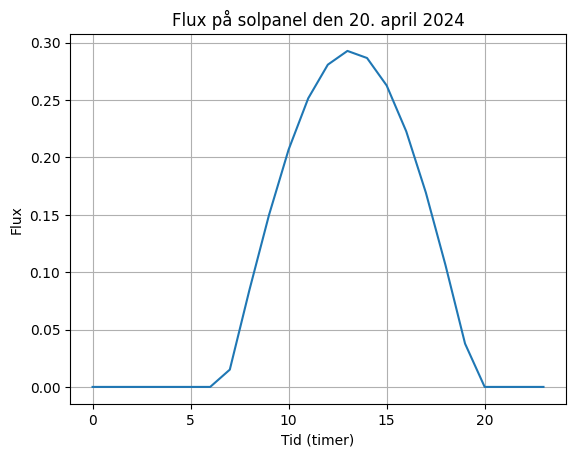

In [142]:
time_index = solpos.loc["2024-04-20"].index
time_array = np.array([t.hour + t.minute/60 for t in time_index])

flux = solar_panel_projection(theta_sol, phi_sol, np.deg2rad(30), np.deg2rad(180))
plt.plot(time_array, flux)
plt.xlabel("Tid (timer)")
plt.ylabel("Flux")
plt.title("Flux på solpanel den 20. april 2024")
plt.grid()
plt.show()

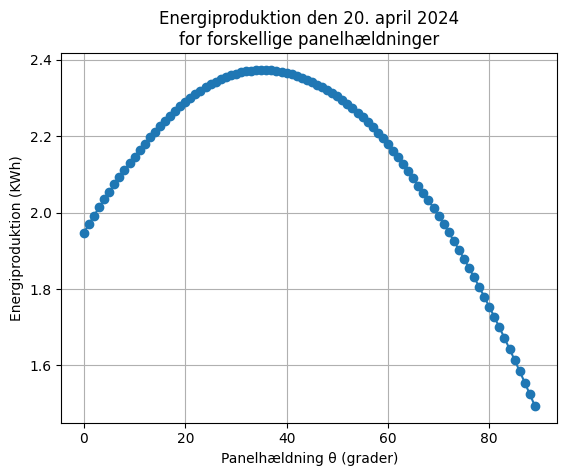

35

In [143]:
hældninger = np.arange(0, 90)  # 0° til 90°
plt.plot(hældninger, wh_energier, marker='o')
plt.xlabel("Panelhældning θ (grader)")
plt.ylabel("Energiproduktion (KWh)")
plt.title("Energiproduktion den 20. april 2024\nfor forskellige panelhældninger")
plt.grid(True)
plt.show()
np.argmax(wh_energier)

In [144]:
# henter pris data
import requests
import pandas as pd

endpoint = "https://api.energidataservice.dk/dataset/elspotprices"
params = {
    "start": "2024-01-01T00:00",
    "end": "2024-12-31T23:00",
    "filter": '{"PriceArea":["DK2"]}'  # <-- fixed JSON string
}

response = requests.get(endpoint, params=params)
data = response.json()
df = pd.DataFrame(data['records'])
# Konverter evt. enheder (øre/kroner, kWh/J/MJ) hvis nødvendigt.
# følgende er forkert, dvs. tidsrumer ganget med forskudte.
print(df)
energi = integrate.simpson(flux_array, dx=3600)
energi

                  HourUTC               HourDK PriceArea  SpotPriceDKK  \
0     2024-12-31T21:00:00  2024-12-31T22:00:00       DK2     59.529999   
1     2024-12-31T20:00:00  2024-12-31T21:00:00       DK2    117.120003   
2     2024-12-31T19:00:00  2024-12-31T20:00:00       DK2    168.509995   
3     2024-12-31T18:00:00  2024-12-31T19:00:00       DK2    180.820007   
4     2024-12-31T17:00:00  2024-12-31T18:00:00       DK2    193.729996   
...                   ...                  ...       ...           ...   
8778  2024-01-01T03:00:00  2024-01-01T04:00:00       DK2    178.990005   
8779  2024-01-01T02:00:00  2024-01-01T03:00:00       DK2    182.490005   
8780  2024-01-01T01:00:00  2024-01-01T02:00:00       DK2    198.740005   
8781  2024-01-01T00:00:00  2024-01-01T01:00:00       DK2    212.160004   
8782  2023-12-31T23:00:00  2024-01-01T00:00:00       DK2    217.160004   

      SpotPriceEUR  
0         7.980000  
1        15.700000  
2        22.590000  
3        24.240000  
4     

5379.092896115253

In [145]:
# nyt solpos object, der paser til mængden fra tidligere, men med gennemsnit over timer, og mangler sidste time af 12-31, 
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "h"  # "Min", "H",

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.47092, 12.31168, tidszone, 10, "Danmarks Tekniske Universitet (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Højde er ca 50 m MOH

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 22:59:59", inclusive="left", freq=delta_tid, tz=tidszone
)

# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)

solpos.zenith.shape

times.shape, 366*24-1




((8783,), 8783)

In [ ]:
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)
    WnLB = 0.185*1.63*550 # n er overførelsen, altså hvor meget energi fra solen er arbejdsom, målt fra når den rammer pannelet til den kommer ind i et andet kredsløb
    u_s = np.array([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ])

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])

    dot_products = WnLB * u_s.T@u_p
    return np.maximum(dot_products, 0)

# solar_panel_projection(np.array([1,2,3]), np.array([1,3,3]), np.array([1]), np.array([1]))

In [150]:
# Flux array constructor
for zenitha in range(0, 91):  # 0° til 90°
    theta_panel = np.deg2rad(zenitha)
    phi_panel = np.deg2rad(1)
    for azimutha in range(0, 360):
        flux_array
    flux_array = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
        0.0)
theta_panel, phi_panel = np.deg2rad(50), np.deg2rad(180)
theta_sol, phi_sol = np.deg2rad(solpos.zenith.values), np.deg2rad(solpos.azimuth.values)

energier = []
wh_energier = []

flux_array = np.where(
    theta_sol <= np.pi / 2,
    solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
    0.0)

print(flux_array[18:1000])
energi = integrate.simpson(flux_array, dx=3600)
print(energi)
energier.append(energi)
wh_energier.append(energi/3600)

print(energier)


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.17152494 0.21897085 0.25074213
 0.26467397 0.25981655 0.23649982 0.1963111  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.17126746 0.21885627 0.25078118
 0.26486684 0.26015287 0.2369594  0.19686526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.17102712 0.21875994 0.25083859
 0.26507715 0.26050477 0.23743184 0.19742894 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.17080414 0.21868195 0.25091429
 0.2653047  0.26087189 0.23791668 0.19800159 0.         0.
 0.         0.         0

In [ ]:
theta_sol.shape

(8783,)

In [ ]:
len(energier)

97

In [ ]:
print(theta_sol.shape)

(8783,)


In [ ]:

# redefinere globale variabler, og constructors for at sikre functionalitet/brug af korrekte data,
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "h" 

site = Location(
    55.47092, 12.31168, tidszone, 10, "Danmarks Tekniske Universitet (DK)"
)

# 
times_hourly = pd.date_range(
    start=start_dato + " 00:00:00",
    end=slut_dato + " 23:00:00", # Inclusive endpoint for the last hour
    freq=delta_tid,
    tz=tidszone
)
print(f"Der er blevet udregnet for {len(times_hourly)} timer {start_dato} til {slut_dato}.")
endpoint = "https://api.energidataservice.dk/dataset/elspotprices"
params = {
    "start": start_dato,
    "end": slut_dato,
    "filter": '{"PriceArea":["DK2"]}',
    "sort": "HourDK ASC"
}
hourly_price_DKK_per_kWh_aligned = None # Initialize


solpos_hourly = site.get_solarposition(times_hourly)
theta_sol_hourly = np.deg2rad(solpos_hourly.zenith.values)
phi_sol_hourly = np.deg2rad(solpos_hourly.azimuth.values)


#

try:
    response = requests.get(endpoint, params=params, timeout=30)
    response.raise_for_status()
    data = response.json()
    df_prices = pd.DataFrame(data['records'])

    df_prices['HourDK'] = pd.to_datetime(df_prices['HourDK'])
    df_prices = df_prices.set_index('HourDK')
    df_prices = df_prices.tz_convert(tidszone)
    hourly_price_DKK_per_kWh = df_prices['SpotPriceDKK'] / 100.0
    hourly_price_DKK_per_kWh_aligned = hourly_price_DKK_per_kWh.reindex(times_hourly).ffill().bfill()

    if len(hourly_price_DKK_per_kWh_aligned) != len(times_hourly):
         hourly_price_DKK_per_kWh_aligned = hourly_price_DKK_per_kWh_aligned.reindex(times_hourly).ffill().bfill()
    print("Data matchede ikke i størrelse, dimensioner med manglenede data er erstattet med 0'er.")

except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
    hourly_price_DKK_per_kWh_aligned = pd.Series(np.zeros(len(times_hourly)), index=times_hourly) # hvis fetching fejler, for vi 0 som output af hele funktionen.

# Sol og panel vektorer til projektionen, som bruges til at finde componenten af irradians der er arbedjsom i panelet. 
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)
    SnLB = 0.185 * 1.63 * 550 # S er solens Irradiance, n er panel effektivitet, LB(længde og bredde) er arealet af panelet.
    u_s = np.array([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ])
    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])
    dot_products = SnLB * u_s.T@u_p
    return np.maximum(dot_products, 0)
# Værdi af strøm generet, som er den integrerede værdi af fluxen over tid, ganget med prisen på strømmen.
def calculate_annual_profit(theta_panel_rad, phi_panel_rad, theta_sol, phi_sol, price_per_kwh):
    hourly_power_W = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel_rad, phi_panel_rad),
        0.0
    )
    hourly_energy_kWh = hourly_power_W / 1000.0
    hourly_value_DKK = hourly_energy_kWh * price_per_kwh.values
    total_value_DKK = np.sum(hourly_value_DKK)
    return total_value_DKK

# --- 6. Systematic Calculation over all Angle Combinations ---

# Define angle ranges (degrees)
tilt_angles_deg = np.arange(0, 91)  # 0 to 90 degrees inclusive
azimuth_angles_deg = np.arange(0, 360) # 0 to 359 degrees inclusive

# Initialize results array
annual_profits = np.zeros((len(tilt_angles_deg), len(azimuth_angles_deg)))

print(f"\nStarting profit calculation for {len(tilt_angles_deg)} tilt angles and {len(azimuth_angles_deg)} azimuth angles...")
print(f"Total combinations: {len(tilt_angles_deg) * len(azimuth_angles_deg)}")

# --- Nested Loops ---
for i, theta_p_deg in enumerate(tilt_angles_deg):
    theta_p_rad = np.deg2rad(theta_p_deg)

    # Print progress every 10 tilt angles
    if (i + 1) % 10 == 0 or i == 0:
         print(f"  Calculating for Tilt Angle: {theta_p_deg}° ({i+1}/{len(tilt_angles_deg)})")

    for j, phi_p_deg in enumerate(azimuth_angles_deg):
        phi_p_rad = np.deg2rad(phi_p_deg)

        # Calculate annual profit
        profit = calculate_annual_profit(
            theta_p_rad,
            phi_p_rad,
            theta_sol_hourly,
            phi_sol_hourly,
            hourly_price_DKK_per_kWh_aligned # Use the aligned price Series
        )
        annual_profits[i, j] = profit

print("Calculation finished.")

# --- 7. Find and Report the Optimal Combination ---

# Find the maximum profit value
max_profit = np.max(annual_profits)

# Find the indices (row, column) of the maximum value
max_indices = np.unravel_index(np.argmax(annual_profits), annual_profits.shape)
optimal_tilt_index = max_indices[0]
optimal_azimuth_index = max_indices[1]

# Get the corresponding optimal angles in degrees
optimal_tilt_deg = tilt_angles_deg[optimal_tilt_index]
optimal_azimuth_deg = azimuth_angles_deg[optimal_azimuth_index]

print("\n--- Optimal Orientation based on Annual Profit (DKK) ---")
print(f"Optimal Tilt Angle (theta_p): {optimal_tilt_deg}°")
print(f"Optimal Azimuth Angle (phi_p): {optimal_azimuth_deg}°")
print(f"Maximum Annual Profit: {max_profit:.2f} DKK")

# --- 8. Optional: Visualization ---
print("\nGenerating profit heatmap...")
plt.figure(figsize=(12, 8))
im = plt.imshow(annual_profits, aspect='auto', origin='lower',
                extent=[azimuth_angles_deg[0]-0.5, azimuth_angles_deg[-1]+0.5,
                        tilt_angles_deg[0]-0.5, tilt_angles_deg[-1]+0.5],
                cmap='viridis')
plt.colorbar(im, label='Annual Profit (DKK)')
plt.xlabel("Azimuth Angle (phi_p) [degrees]")
plt.ylabel("Tilt Angle (theta_p) [degrees]")
plt.title("Annual Profit vs. Panel Orientation (DK2 Prices 2024)")
plt.scatter([optimal_azimuth_deg], [optimal_tilt_deg], color='red', marker='x', s=150, linewidth=3, label=f'Optimum\n({optimal_tilt_deg}°, {optimal_azimuth_deg}°)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.xticks(np.arange(0, 361, 45))
plt.yticks(np.arange(0, 91, 10))
plt.show()
print("Heatmap generated.")

1